<a href="https://colab.research.google.com/github/DiegoEspinozaoss/Privacidad_de_Datos_CC5215-1/blob/main/Laboratorio_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CC5215: Privacidad de Datos
## Laboratorio 2

**Integrantes**
- Diego Espinoza Núñez
- Lucas Orellana Jara

In [ ]:
# Load the data and libraries
import pandas as pd
import numpy as np

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

# Dataset with private information
adult_pii = adult[['Name', 'DOB', 'SSN', 'Zip', 'Age']]
# Deanonimized dataset
adult_deid = adult[['DOB', 'Zip', 'Age', 'Target']].dropna(subset=['Target'])

# quasi-identifiers
qis = ['Age', 'Zip']

In the previous lab, in order to achieve 5-anonimity for the dataset `adult_deid` we had to essentially either get rid of the column 'Age' or 'Zip'. This was due to the presence of outliers which, no matter how much we generalized before losing a column, they were always distinguishable from the rest of the dataset.

In this laboratory, we will use other mechanisms of generalization and anonimization of the dataset in order to achieve a certain level of $k$-anonimity without having to get rid of entire columns. Additionally, we will aim to also satisfy some level of $l$-diversity.

We will only work with the dataset `adult_deid` and measure $l$-diversity for the column 'Target'.

## Question 1 (10 points)

In the previous lab you defined a `generalize` function to mask the less-significant digits of a numeric column. Whereas it may be intuitive to generalize the column 'Zip' using this method, it is not so obvious for the column 'Age' (we only have two options: intervals of 10 or 100!). We have renamed the function `generalize` to `mask_with_zeros` and re-defined it to operate on the whole dataset.

Define a function `generalize_by_intervals` that converts a numeric column in its interval counterpart. This function should be parametrized by the size of the intervals, and assume that intervals start at zero, i.e. [0, 5), [5, 10), etc.

In [ ]:
# mask_with_zeros was previously named generalize
def mask_with_zeros(df, depths):
    """
    Returns a copy of `df` where the numeric column declared in `depths` are
    generalized by replacing the least significant digits (also specified by
    `depths`) with zeros
    """
    new_df = df.copy()
    for col, depth in depths.items():
        factor = 10 ** depth
        new_df[col] = new_df[col].apply(lambda value: factor * int(value / factor))

    return new_df

In [ ]:
def build_interval(value, interval_size):
    """
    Construye un string que representa el intervalo al cual pertenece el valor.
    """
    start = (value // interval_size) * interval_size
    return f"[{start}, {start + interval_size})"

def generalize_by_intervals(df, col, interval_size):
    """
    Returns a copy of `df` where the column 'col' is generalized in a way such
    that every value is transformed to an interval of size `interval_size`
    """
    new_df = df.copy()
    # Asumimos que todas las columnas del dataset están bien definidas
    new_df[col] = new_df[col].apply(lambda value: build_interval(value, interval_size))
    return new_df

In [ ]:
# adult_deid with age splitted in intervals of 5
adult_deid_gen = generalize_by_intervals(adult_deid, 'Age', 5)

assert adult_deid['Age'].nunique() == 73
# there should be only 16 possible values for 'Age'
assert adult_deid_gen['Age'].nunique() == 16

## Question 2 (5 points)

The generalization using intervals should improve the anonimity of our dataset. Plot the histogram for the column 'Age' of the datasets `adult_deid` and `adult_deid_gen` in order to observe how the distribution of values have changed.

*Hint*: use the `hist` function.





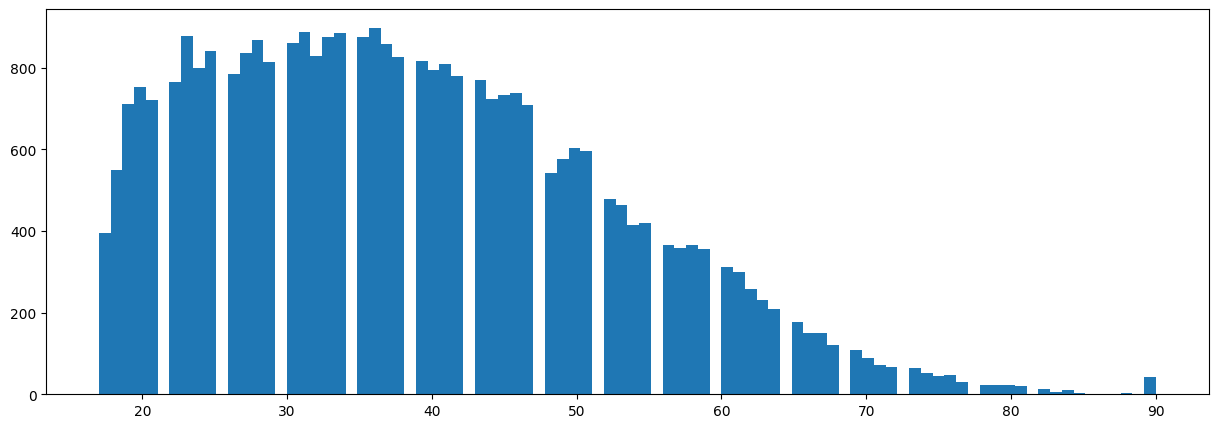

In [ ]:
# Histograma de adult_deid
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.hist(adult_deid['Age'], bins=90)
plt.show()

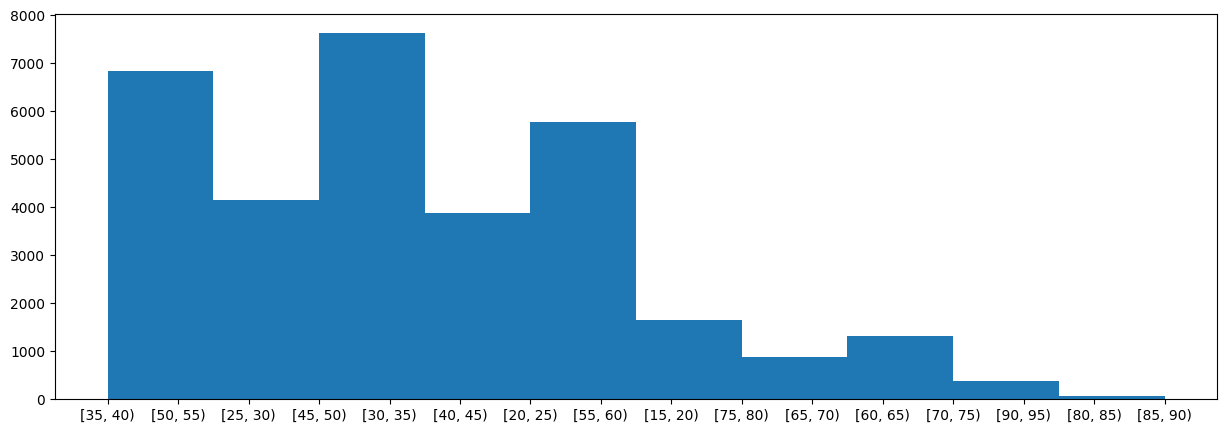

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(adult_deid_gen['Age'])
plt.show()

- Do you think that generalizing by intervals will be enough to get rid of outliers?

En algunos casos la generalización por intervalos es suficiente para deshacerse de los outliers, dependiendo claramente de qué tan amplios son los rangos dentro de los que se generaliza. Por ejemplo, si tuviésemos un solo individuo entre los $85$ y $90$ años, la generalización por intervalos hubiese entregado un grupo de entre $85$ y $90$ años con un solo individuo, obteniendo así un dataset $1$-anónimo de todas formas.


## Question 3 (5 points)

In order to measure how good our generalizations are we need a way to compute the index of anonimity.

Define a function `compute_anonimity_index` that calculates the (greatest) $k$ for which the dataset is $k$-anonymous, namely, the anonimity index.

In [ ]:
def compute_anonimity_index(df, qis):
    qis_count = df.groupby(qis).size()
    k = qis_count.min()
    return k

In [ ]:
assert compute_anonimity_index(adult_deid, qis) == 1
# Test from last lab
assert compute_anonimity_index(mask_with_zeros(adult_deid, { 'Zip': 2, 'Age': 2 }), qis) >= 5

## Question 4 (10 points)

Define a function `compute_diversity_index` that calculates the $l$ for which the dataset is $l$-diverse (for distinct diversity) for a given sensitive attribute, namely, the diversity index.

*Hint*: You can use the `groupby` method for dataframes and the `nunique` method for series in order to calculate the index.

In [ ]:
def compute_diversity_index(df, qis, target):
    """
    Calcula el valor de l-diversidad para el dataset dado.
    """
    # Agrupamos por los QIs y contamos los valores únicos del atributo sensible
    diversity_counts = df.groupby(qis)[target].nunique()

    # l-diversidad del dataset es el menor valor encontrado
    l = diversity_counts.min() if not diversity_counts.empty else 0

    return l

In [ ]:
adult_deid_gen = mask_with_zeros(adult_deid_gen, { 'Zip': 4 })

assert compute_diversity_index(adult_deid_gen, qis, 'Target') == 1

## Question 5 (10 points)

- Plot an histogram that illustrates the number of groups (grouped by our quasi-identifiers) vs the number of different sensitive values in each group, for the generalized dataframe.


In [ ]:
adult_deid_gen

,DOB,Zip,Age,Target
0,9/7/1967,0,90,<=50K
1,6/7/1988,0,90,<=50K
2,8/6/1991,0,90,<=50K
3,4/6/2009,0,90,<=50K
4,9/16/1951,0,90,<=50K
...,...,...,...,...
32556,10/29/1961,0,90,<=50K
32557,6/28/1952,0,90,>50K
32558,8/9/1966,0,90,<=50K
32559,5/19/1978,0,90,<=50K


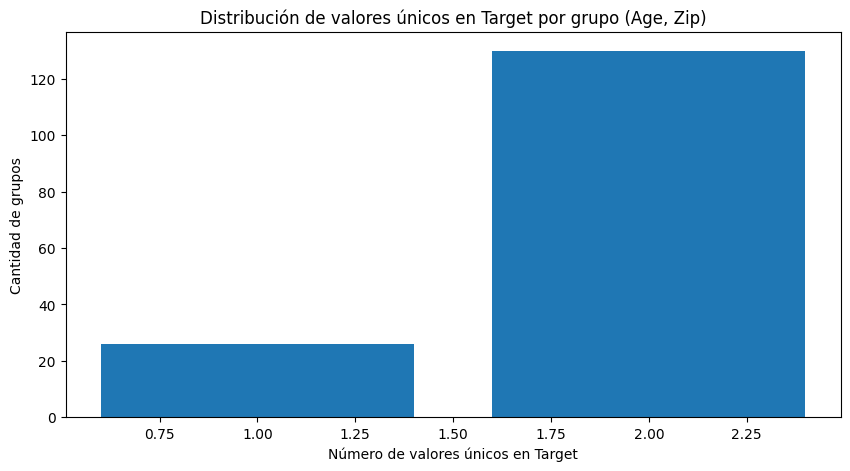

In [ ]:
grouped_counts = adult_deid_gen.groupby(['Age', 'Zip'])['Target'].nunique()

group_distribution = grouped_counts.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(group_distribution.index, group_distribution.values, width=0.8)

plt.xlabel("Número de valores únicos en Target")
plt.ylabel("Cantidad de grupos")
plt.title("Distribución de valores únicos en Target por grupo (Age, Zip)")

plt.show()


- Write the code to find what rows contain only one unique sensitivity value (`'Target'`) when grouped by the quasi-identifies `['Age', 'Zip']`.

In [ ]:
# Agrupamos por QIs y contamos valores únicos en Target
single_value_groups = adult_deid_gen.groupby(['Age', 'Zip'])['Target'].nunique()

# Filtramos grupos donde Target tiene solo 1 valor único
single_value_groups = single_value_groups[single_value_groups == 1].index

# Filtramos el DataFrame original para obtener las filas de esos grupos
rows_with_single_target = adult_deid_gen[adult_deid_gen.set_index(['Age', 'Zip']).index.isin(single_value_groups)]

display(rows_with_single_target)

,DOB,Zip,Age,Target
51,10/11/1961,60000,"[15, 20)",<=50K
70,3/20/1974,40000,"[15, 20)",<=50K
78,7/10/1954,20000,"[15, 20)",<=50K
80,2/24/1956,40000,"[15, 20)",<=50K
106,5/22/2005,60000,"[15, 20)",<=50K
...,...,...,...,...
32443,5/5/1960,0,"[15, 20)",<=50K
32447,2/4/2011,50000,"[15, 20)",<=50K
32459,7/26/2012,20000,"[85, 90)",<=50K
32494,8/25/1983,60000,"[80, 85)",<=50K


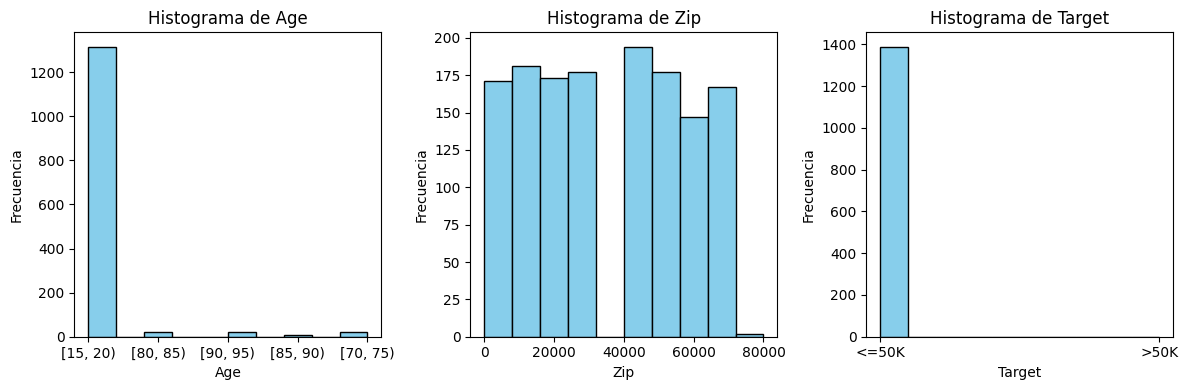

In [ ]:
import matplotlib.pyplot as plt

cols = ["Age", "Zip", "Target"]

plt.figure(figsize=(12, 4))

for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    plt.hist(rows_with_single_target[col], bins=10, color="skyblue", edgecolor="black")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.title(f"Histograma de {col}")

plt.tight_layout()
plt.show()


- Describe the outliers.



```

```

Your answer here:

Con respecto al dataframe original (adult_deid), a priori no podemos saber si todos estos 1389 puntos son outliers, porque a priori dado que adult_deid_gen es el dataframe ya generalizado no podemos saber qué edades son. Por otro lado, con respecto al dataframe adult_deid_gen tenemos que decir si son todos outliers o no son todos outliers. El dataframe rows_with_single_target contiene solo outliers porque son aquellos conjuntos de cuasi identificadores que aparecen solo una vez en el dataframe generalizado. Estos puntos atípicos son tales que la distribución de las personas por su Zip code es casi homogénea, cuyo atributo Age o edad es casi siempre o en su mayoría entre 15 y 20 años y su atributo sensible Target es casi siempre mayor o igual a 50 mil. Podemos decir entonces que en general son personas que son o bien menores de edad o de la tercera edad, y que por lo tanto no son trabajadores o bien no forman parte de la masa que puede participar de una votación popular.

## Question 6 (5 points)

- Write a function `generalize_by_bounds` that sets a lower and upper bound to a numeric column.



In [ ]:
def generalize_by_bounds(df, col, lower, upper):
    """
    Creates a new dataframe from `df` where the column 'col' is
    generalized in a way such that every value below or equal to `lower` is
    replaced by `lower`, and every value above `upper` is replaced by `upper`
    """
    new_df = df.copy()
    new_df[col] = new_df[col].clip(lower=lower, upper=upper)

    return new_df

- Use the `generalize_by_bounds` function to achieve 2-diversity and 41-anonimity.



In [ ]:
# Sacamos una lista con los valores únicos en 'Age' posibles
age_values = list(range(adult_deid['Age'].min(), adult_deid['Age'].max() + 1))

best_result = None

# Iteramos combinaciones de límites de edad y enmascaramiento del 'Zip'
for z in [0, 1, 2, 3, 4, 5]:
    adult_deid_zip_masked = mask_with_zeros(adult_deid, {'Zip': z})

    for i, l in enumerate(age_values):
        for u in age_values[i:]:  # Forzamos que siempre se cumpla l <= u
            # Aquí aplicamos generalización a la columna Age
            adult_deid_gen = generalize_by_bounds(adult_deid_zip_masked, 'Age', l, u)

            # Cálculo de métricas
            ldiv = compute_diversity_index(adult_deid_gen, qis, 'Target')
            kanon = compute_anonimity_index(adult_deid_gen, qis)

            # Si encontramos una solución óptima, la mostramos
            if ldiv == 2 and kanon == 41:
                best_result = (l, u, z)
                print(f"Configuración encontrada: lower = {best_result[0]}, upper = {best_result[1]}, mask = {best_result[2]}")

if best_result:
    print('\nEncontradas todas las configuraciones válidas')
else:
    print("No se encontró una configuración válida.")

Configuración encontrada: lower = 48, upper = 53, mask = 4
Configuración encontrada: lower = 49, upper = 53, mask = 4
Configuración encontrada: lower = 50, upper = 53, mask = 4
Configuración encontrada: lower = 51, upper = 53, mask = 4
Configuración encontrada: lower = 69, upper = 70, mask = 4

Encontradas todas las configuraciones válidas


Las configuraciones encontradas que dan como resultado $l$-div $= 2$ y $k$-anon $ = 41$ son las siguientes:

| 'Age' lower | 'Age' upper | 'Zip' mask |
|-------------|-------------|------------|
| 48          | 53          | 4          |
| 49          | 53          | 4          |
| 50          | 53          | 4          |
| 51          | 53          | 4          |
| 69          | 70          | 4          |

In [ ]:
adult_deid_2div = generalize_by_bounds(adult_deid, 'Age', 48, 53)
adult_deid_2div = mask_with_zeros(adult_deid_2div, {'Zip': 4})

ldiv = compute_diversity_index(adult_deid_2div, qis, 'Target')
kanon = compute_anonimity_index(adult_deid_2div, qis)

assert ldiv == 2
assert kanon == 41

print("The final diversity index is:", ldiv)
print("The final anonimity index is:", kanon)

The final diversity index is: 2
The final anonimity index is: 41


In [ ]:
# Echemos un vistazo a cómo quedaron los datos con esta configuración:
adult_deid_2div.head()

,DOB,Zip,Age,Target
0,9/7/1967,60000,48,<=50K
1,6/7/1988,60000,50,<=50K
2,8/6/1991,90000,48,<=50K
3,4/6/2009,20000,53,<=50K
4,9/16/1951,70000,48,<=50K


- Describe using natural language the changes done to the original dataframe.

Lo que se le hizo a los datos originales fueron cambios en dos de sus columnas:
1. Con respecto a 'Age', se acotaron en un rango dado:

    a. Las edades menores o iguales a 48 se igualan a 48

    b. Las edades entre 48 y 53 se mantienen tal cual

    c. Las edades mayores o iguales a 53 se igualaln a 53

2. Para el 'Zip', se enmascararon los últimos 4 dígitos, por lo que estos códigos varían desde el número $0$ hasta el $90.000$, avanzando en múltiplos de $10.000$

## Question 7 (15 points)

The entropic diversity of a QID group measures how evenly the private values of some attribute $S$ are distributed in that group. It is formally defined as
$$-\sum_{v\in S}\mathtt{P}(\mathit{QIds}, v)*\mathtt{log}(\mathtt{P}(\mathit{QIds}, v))$$
where $\mathtt{P}(\mathit{QIds}, v)$ corresponds to the fraction of records in the $\mathit{QIds}$ group with value $v$ for the attribute $S$.
For example, for the following table where disease is a sensitive data:

| Job | Sex | Age | Disease |
| --- | --- | --- | --- |
| Professional | F | [35-40) | Hepatitis |
| Professional | F | [35-40) | Hepatitis |
| Professional | F | [35-40) | VIH |
| Artist | M | [35-35) | Flu |
| Artist | M | [35-35) | VIH |
| Artist | M | [35-35) | VIH |
| Artist | M | [35-35) | VIH |

The entropic diversity of the group (Professional, F, [35-40)) is $-(\frac{2}{3}\mathtt{log}\frac{2}{3} + \frac{1}{3}\mathtt{log}\frac{1}{3}) = \mathtt{log}(1.9)$, and the entropic diversity of group (Artist, M, [35-35)) is $-(\frac{3}{4}\mathtt{log}\frac{3}{4} + \frac{1}{4}\mathtt{log}\frac{1}{4}) = \mathtt{log}(1.8)$.

The entropic diversity of a table is the minimum of all the entropic diversities among all QIds.

Write a function that computes the entropic diversity of a dataframe.

Hint: Investigate what the following calls do in pandas: `...value_counts(normalize=True)` and `...reset_index(name='...')`

In [ ]:
def l_entropic_diversity(df, qis, target):
    """
    Computes the entropic diversity of a dataframe given the QIDs qis, and the sensitive attribute target.
    """
    grouped = df.groupby(qis)[target].value_counts(normalize=True).reset_index(name='probabilidad')

    # Evitar problemas con log(0)
    grouped = grouped[grouped['probabilidad'] > 0]
    print(grouped )
    p = grouped['probabilidad']
    #print(p)
    grouped['entropia'] = -p * np.log(p)

    entropic_diversity = grouped.groupby(qis)['entropia'].sum()

    return entropic_diversity.min() if not entropic_diversity.empty else 0


In [ ]:

l_entropic_diversity = l_entropic_diversity(adult_deid_2div, qis, 'Target')

     Age    Zip Target  probabilidad
0     48      0  <=50K      0.796794
1     48      0   >50K      0.203206
2     48  10000  <=50K      0.804888
3     48  10000   >50K      0.195112
4     48  20000  <=50K      0.790902
..   ...    ...    ...           ...
115   53  70000   >50K      0.330373
116   53  80000  <=50K      0.696028
117   53  80000   >50K      0.303972
118   53  90000  <=50K      0.719331
119   53  90000   >50K      0.280669

[120 rows x 4 columns]


In [ ]:

print("Valor de l_entropic_diversity:", float(l_entropic_diversity))
print("Diferencia absoluta:", abs(float(l_entropic_diversity) - 0.02490171502983102))


Valor de l_entropic_diversity: 0.4935513445316162
Diferencia absoluta: 0.4686496295017852


In [ ]:
import numpy as np

assert np.isclose(float(l_entropic_diversity), 0.02490171502983102, atol=1e-0)